# 3rd Exercise link:
> https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb

In [1]:
!nvidia-smi

Sun Mar  2 20:10:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.17              Driver Version: 572.47         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   63C    P8             16W /  150W |     664MiB /  16384MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports and constants

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

print("GPU available: ", torch.cuda.is_available())
print(torch.__version__)

GPU available:  True
2.4.1


In [3]:
MANUAL_SEED = 42
DATA_FOLDER = "../inputs/"
BATCH_SIZE = 32

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

# DATA

In [ ]:
train_data = torchvision.datasets.MNIST(root=DATA_FOLDER, train=True, download=False, transform=ToTensor(), target_transform=None)
test_data = torchvision.datasets.MNIST(root=DATA_FOLDER, train=False, download=False, transform=ToTensor(), target_transform=None)

In [ ]:
len(train_data), len(test_data)

In [ ]:
CLASSNAMES = list((train_data.class_to_idx).values())
CLASSNAMES, train_data.targets, train_data.class_to_idx

In [ ]:
img, label = train_data[2]
img.shape, label

In [ ]:
t=1
for x in list(img.shape):
    t*=x
t

### EDA

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(f"Image shape: {img.shape}")
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
in_channels=1
out_channels=10
hidden_channels=10
in_img = train_features[0].to(DEVICE)
conv1_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=0, device=DEVICE),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=0, device=DEVICE),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
        )
conv_in = nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, device=DEVICE)
relu_in = nn.ReLU()
conv_h_in = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, device=DEVICE)
maxp_in = nn.MaxPool2d(kernel_size=2, stride=2)
flatten_in = nn.Flatten()
# linear_in = nn.Linear(in_features=dense_features, out_features=out_channels, device=DEVICE)

In [ ]:
print(f"Input Shape: {in_img.shape}")
fn_map = {
    conv_in: "Conv_in",
    relu_in: "RelU",
    conv_h_in: "Conv_hidden",
    maxp_in: "Maxpool",
    flatten_in: "Flatten",
    "Linear": "Linear"
}
seq_list = [conv_in, conv_h_in, maxp_in, conv_h_in, conv_h_in, maxp_in, flatten_in, "Linear"] maxp_in#conv_in, relu_in, conv_h_in, 
shapes_dict = {}
out_img = None
for i in seq_list:
    a = in_img if out_img is None else out_img
    if fn_map[i] == "Flatten":
        a = a.unsqueeze(0)
        print(f"Change in shape: {a.shape}")
    if fn_map[i] == "Linear":
        dense_features = a.shape[-1]
        l_fn = nn.Linear(in_features=dense_features, out_features=10, device=DEVICE)
        out_img = l_fn(a).squeeze()
    else:
        out_img = i(a)
    print(f"{fn_map[i]}: {out_img.shape}")
    shapes_dict[fn_map[i]] = out_img.shape
# print(f"Change in shape: {shapes_dict}")

In [ ]:
plt.figure(figsize=(15,7))
for i in range(1, 7):
    rand_idx = torch.randint(0, len(train_data), size=(1,)).item()
    img, label = train_data[rand_idx]
    plt.subplot(2, 3, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(f"{label} | {(img.squeeze()).shape}")
    plt.axis(False);

# Data Loading

In [ ]:
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader)

In [9]:
class cv_model(nn.Module):
    counter = 1
    def __init__(self, in_channels, out_channels, hidden_channels):
        super().__init__()
        self.out_channels = out_channels
        self.dense_features = 1
        self.conv1_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, device=DEVICE),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2_layer = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, device=DEVICE),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, device=DEVICE),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten_layer = nn.Flatten()
        # self.dense_layer = nn.Linear(in_features=linear_channels, out_features=out_channels, device=DEVICE)
        # self.dense_layer = nn.Linear(in_features=self.dense_features, out_features=self.out_channels, device=DEVICE)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(hidden_channels*7*7), out_features=out_channels, device=DEVICE),
        )
    def forward(self, x):
        x = self.conv1_layer(x)
        if self.counter == 1:
            print(x.shape)
        x = self.conv2_layer(x)
        if self.counter == 1:
            print(x.shape)
        # x = self.flatten_layer(x)
        
        # self.dense_features = x.shape[-1]
        # x = self.dense_layer(x)
        x = self.classifier(x)
        if self.counter == 1:
            print(x.shape)
            self.counter = 0
        return x


In [ ]:
model_1 = cv_model(in_channels=1, out_channels=10, hidden_channels=10).to(DEVICE)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim_ = torch.optim.SGD(params=model_1.parameters())

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = 0
    for x_train, y_train in train_dataloader:
        x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
        model_1.train()
        y_pred = model_1(x_train)
        loss = loss_fn(y_pred, y_train)
        train_loss += loss
        optim_.zero_grad()
        loss.backward()
        optim_.step()
    train_loss /= len(train_dataloader)
    
    test_loss = 0
    model_1.eval()
    with torch.inference_mode():
        for x_test, y_test in test_dataloader:
            x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
            test_pred = model_1(x_test)
            t_loss = loss_fn(test_pred, y_test)
            test_loss += t_loss
        test_loss /= len(test_dataloader)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.2f}| Test loss: {test_loss:.2f}")

In [ ]:
plt.figure(figsize=(15,7))
for i in range(1, 7):
    rand_idx = torch.randint(0, len(train_data), size=(1,)).item()
    img, label = train_data[rand_idx]
    rand_img = img.unsqueeze(0)
    prediction = model_1(rand_img.to(DEVICE))
    pred_ = torch.softmax(prediction.squeeze(), dim=0).argmax()
    plt.subplot(2, 3, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(f"Actual: {label} | Pred: {pred_.cpu().numpy()}")
    plt.axis(False);

In [ ]:
rand_idx = torch.randint(0, len(train_data), size=(1,)).item()
rand_idx

In [ ]:
img, label = train_data[rand_idx]
# plt.subplot(2, 3, i)
plt.imshow(img.squeeze(), cmap="grey")
plt.title(f"{label} | {(img.squeeze()).shape}")
plt.axis(False);

In [ ]:
y_preds = []
model_1.eval()
with torch.inference_mode():
    for x, y in test_dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        y_logits = model_1(x)
        y_pred = torch.softmax(y_logits, dim=0).argmax(dim=1)
        y_preds.append(y_pred)
    y_pred_tensor = torch.cat(y_preds).cpu()

In [ ]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(CLASSNAMES))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

In [ ]:
confmat_tensor.numpy()

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=CLASSNAMES, figsize=(10, 7))

# FashionMNIST

In [4]:
train_data = torchvision.datasets.FashionMNIST(root=DATA_FOLDER, train=True, download=False, transform=ToTensor())
test_data = torchvision.datasets.FashionMNIST(root=DATA_FOLDER, train=False, download=False, transform=ToTensor())
len(train_data), len(test_data)

(60000, 10000)

In [5]:
CLASSNAMES = list((train_data.class_to_idx).values())
CLASSNAMES, train_data.targets, train_data.class_to_idx

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 tensor([9, 0, 0,  ..., 3, 0, 5]),
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [12]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

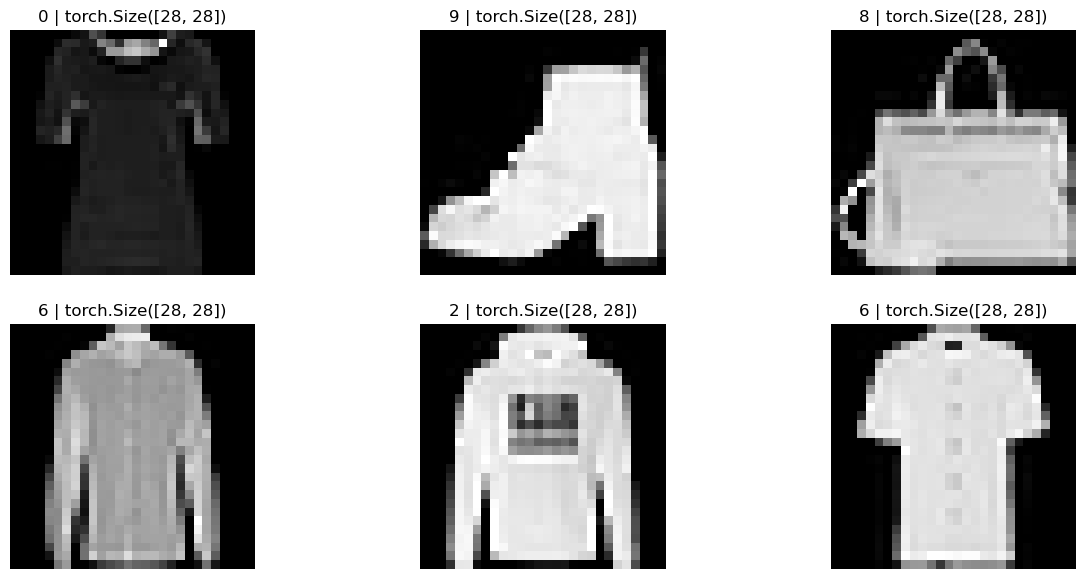

In [13]:
plt.figure(figsize=(15,7))
for i in range(1, 7):
    rand_idx = torch.randint(0, len(train_data), size=(1,)).item()
    img, label = train_data[rand_idx]
    plt.subplot(2, 3, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(f"{label} | {(img.squeeze()).shape}")
    plt.axis(False);

In [14]:
f_model = cv_model(in_channels=1, out_channels=10, hidden_channels=10).to(DEVICE)

In [15]:
%%time
EPOCHS = 10
optim_ = torch.optim.Adam(params=f_model.parameters())
loss_fn = nn.CrossEntropyLoss()
for epoch in range(EPOCHS):
    train_loss = 0
    for x_train, y_train in train_dataloader:
        x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
        f_model.train()
        y_pred = f_model(x_train)
        loss = loss_fn(y_pred, y_train)
        train_loss += loss
        optim_.zero_grad()
        loss.backward()
        optim_.step()
    train_loss /= len(train_dataloader)
    
    test_loss = 0
    f_model.eval()
    with torch.inference_mode():
        for x_test, y_test in test_dataloader:
            x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
            test_pred = f_model(x_test)
            t_loss = loss_fn(test_pred, y_test)
            test_loss += t_loss
        test_loss /= len(test_dataloader)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.2f}| Test loss: {test_loss:.2f}")

torch.Size([32, 10, 14, 14])
torch.Size([32, 10, 7, 7])
torch.Size([32, 10])
Epoch: 0 | Train loss: 0.53| Test loss: 0.40
Epoch: 1 | Train loss: 0.35| Test loss: 0.34
Epoch: 2 | Train loss: 0.31| Test loss: 0.31
Epoch: 3 | Train loss: 0.29| Test loss: 0.30
Epoch: 4 | Train loss: 0.27| Test loss: 0.29
Epoch: 5 | Train loss: 0.26| Test loss: 0.29
Epoch: 6 | Train loss: 0.25| Test loss: 0.29
Epoch: 7 | Train loss: 0.24| Test loss: 0.28
Epoch: 8 | Train loss: 0.23| Test loss: 0.27
Epoch: 9 | Train loss: 0.22| Test loss: 0.27
CPU times: user 1min 18s, sys: 17.8 s, total: 1min 36s
Wall time: 1min 15s


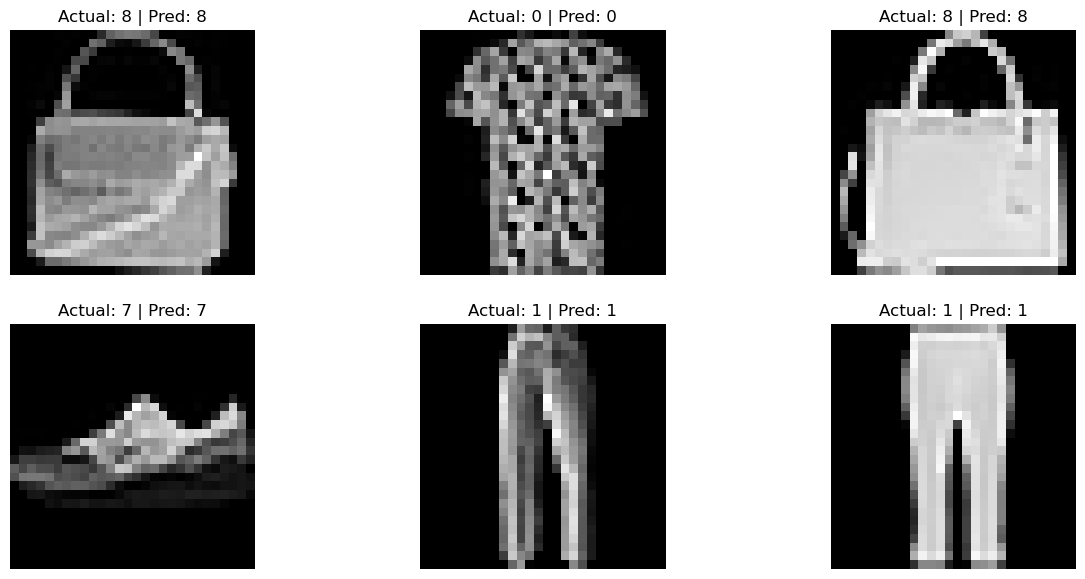

In [16]:
plt.figure(figsize=(15,7))
for i in range(1, 7):
    rand_idx = torch.randint(0, len(train_data), size=(1,)).item()
    img, label = train_data[rand_idx]
    rand_img = img.unsqueeze(0)
    prediction = f_model(rand_img.to(DEVICE))
    pred_ = torch.softmax(prediction.squeeze(), dim=0).argmax()
    plt.subplot(2, 3, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(f"Actual: {label} | Pred: {pred_.cpu().numpy()}")
    plt.axis(False);

In [18]:
y_preds = []
f_model.eval()
with torch.inference_mode():
    for x, y in test_dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        y_logits = f_model(x)
        y_pred = torch.softmax(y_logits, dim=0).argmax(dim=1)
        y_preds.append(y_pred)
    y_pred_tensor = torch.cat(y_preds).cpu()

In [19]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(CLASSNAMES))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

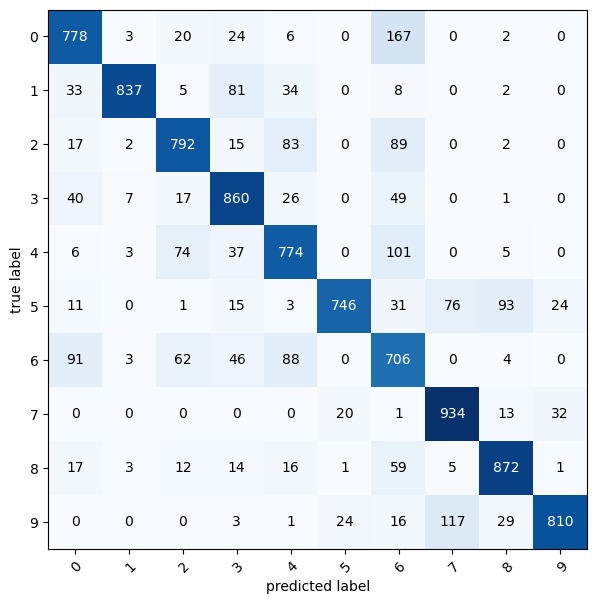

In [20]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=CLASSNAMES, figsize=(10, 7))

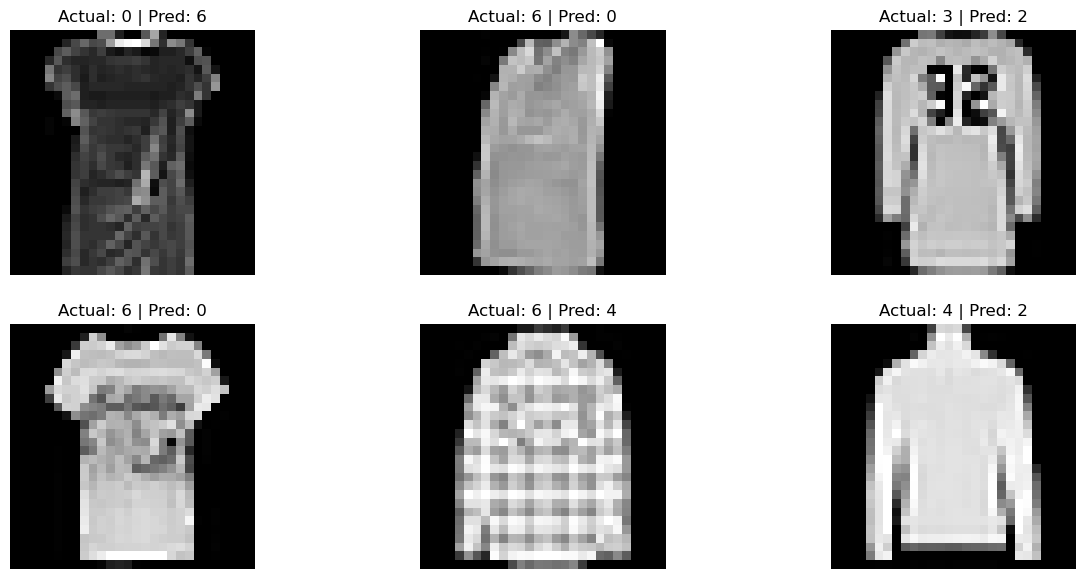

In [23]:
plt.figure(figsize=(15,7))
i=1
while i!=7:
    rand_idx = torch.randint(0, len(train_data), size=(1,)).item()
    img, label = train_data[rand_idx]
    rand_img = img.unsqueeze(0)
    prediction = f_model(rand_img.to(DEVICE))
    pred_ = torch.softmax(prediction.squeeze(), dim=0).argmax()
    if pred_ != label:
        plt.subplot(2, 3, i)
        i+=1
        plt.imshow(img.squeeze(), cmap="grey")
        plt.title(f"Actual: {label} | Pred: {pred_.cpu().numpy()}")
        plt.axis(False);

In [26]:
test_data.targets.numpy(), y_pred_tensor.numpy()

(array([9, 2, 1, ..., 8, 1, 5]), array([9, 2, 1, ..., 8, 4, 6]))

In [28]:
np.mean(test_data.targets.numpy() == y_pred_tensor.numpy())

np.float64(0.8109)